In [1]:
from nilearn import image, plotting
import numpy as np
import pandas as pd
import os
import time
import matplotlib.pyplot as plt
import seaborn as sns
from nilearn.glm.first_level import make_first_level_design_matrix
from nilearn.plotting import plot_design_matrix
from nilearn.glm.first_level import FirstLevelModel

In [2]:
input_directory='/zpool/vladlab/data_drive/fmri_tutorial/derivatives' # The dataset to process
target_directory='/zpool/vladlab/data_drive/fmri_tutorial/derivatives' # The directory to store the preprocessed data
subject='spaceloc1001' # The subject to process

vols = 321 # Number of volumes in the fMRI data
tr = 1 # Repetition time in seconds
runs = 4 # Number of runs in the fMRI data
runs2use = [1,3,5,6]
#load func file for run-01
#func_file = f'{input_directory}/sub-{subject}/ses-01/func/sub-{subject}_ses-01_task-spaceloc_run-01_bold.nii.gz'
#func_img = image.load_img(func_file)
stimdur = 20 # Duration of the stimulus in seconds

#anat = image.load_img(f'{input_directory}/sub-{subject}/ses-01/anat/sub-spaceloc1001_ses-01_space-MNI152NLin2009cAsym_desc-preproc_T1w.nii.gz')
brain_mask = image.load_img(f'{input_directory}/sub-{subject}/ses-01/func/sub-spaceloc1001_ses-01_task-spaceloc_run-01_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz')
brain_mask_data = brain_mask.get_fdata()


#confound cols
confound_cols = ['trans_x', 'trans_y', 'trans_z', 'rot_x', 'rot_y', 'rot_z']



### Set up design matrix

In [30]:
conds = ['SA','FT'] # Conditions of the experiment
run = 1
events = pd.DataFrame(columns=['onset', 'duration', 'trial_type'])
all_events = []
all_confounds = []
all_imgs = []

for run in runs2use:
    for cond in conds:
        cov = pd.read_csv(f'{input_directory}/sub-{subject}/ses-01/covs/SpaceLoc_spaceloc1001_Run{run}_{cond}.txt', sep='\t', header=None)

        # add to events DataFrame
        events = pd.concat([events, pd.DataFrame({
            'onset': cov[0],
            'duration': stimdur,
            'trial_type': cond
        })], ignore_index=True)

    # load confounds file
    confounds = pd.read_csv(f'{input_directory}/sub-{subject}/ses-01/func/sub-spaceloc1001_ses-01_task-spaceloc_run-01_desc-confounds_timeseries.tsv', sep='\t')
    confounds = confounds[confound_cols]

    #append confounds and events to lists
    all_confounds.append(confounds)
    all_events.append(events)

    # load functional image for the run
    img = image.load_img(f'{input_directory}/sub-{subject}/ses-01/func/sub-{subject}_ses-01_task-spaceloc_run-0{run}_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz')
    all_imgs.append(img)

    #img = image.load_img(f'{input_directory}/sub-{subject}/ses-01/func/sub-{subject}_ses-01_task-spaceloc_run-0{run}_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz')

/tmp/ipykernel_899115/223721319.py:13: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  events = pd.concat([events, pd.DataFrame({


In [36]:
fmri_glm = FirstLevelModel(t_r=tr,hrf_model='spm + derivative', smoothing_fwhm=6)
fmri_glm = fmri_glm.fit(all_imgs, all_events, all_confounds)

In [37]:
SA_FT = fmri_glm.compute_contrast('SA - FT')

/tmp/ipykernel_899115/209985408.py:1: UserWarning: One contrast given, assuming it for all 4 runs
  SA_FT = fmri_glm.compute_contrast('SA - FT')


In [41]:
#save the contrast image
output_file = f'{target_directory}/sub-{subject}/ses-01/sa_ft_contrast.nii.gz'
SA_FT.to_filename(output_file)

/home/tuc66980@tu.temple.edu/.conda/envs/fmri/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:868: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)



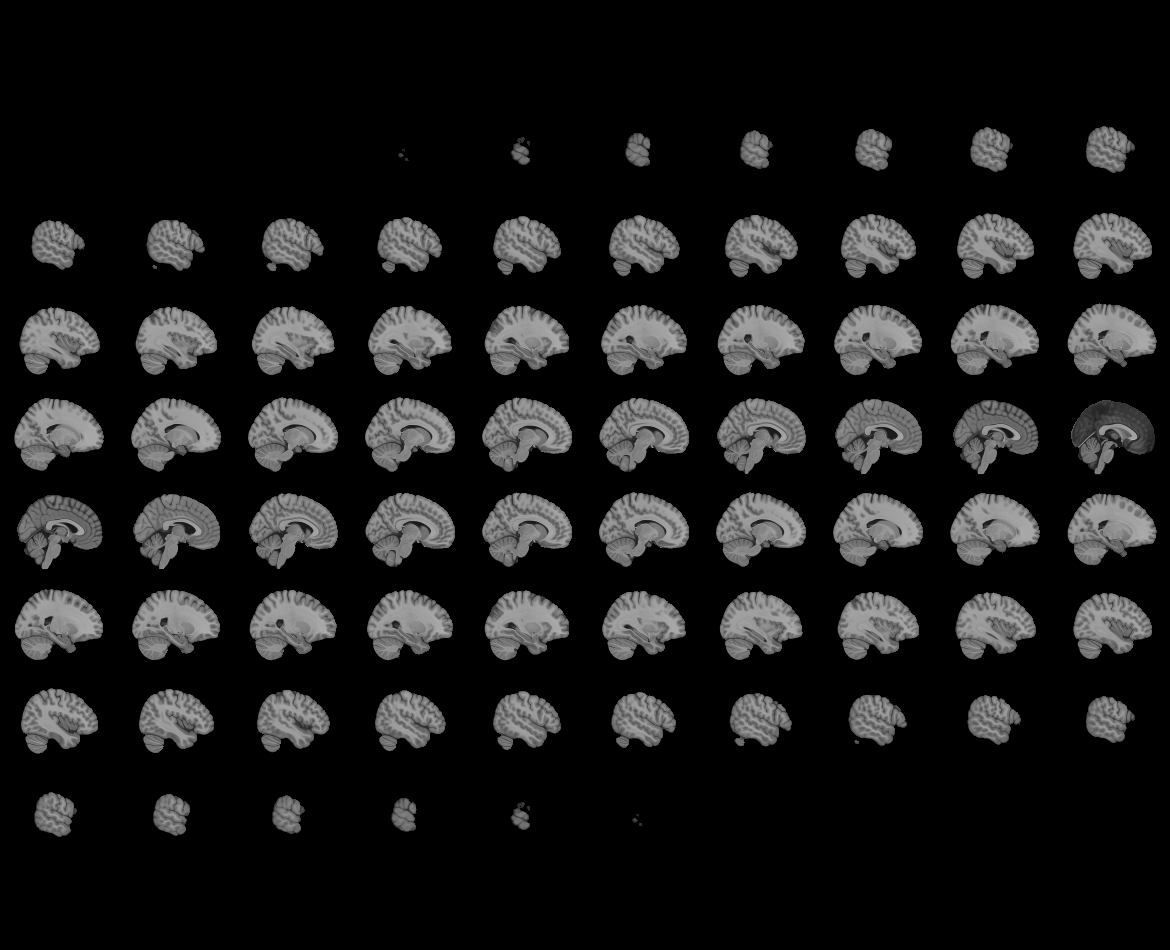
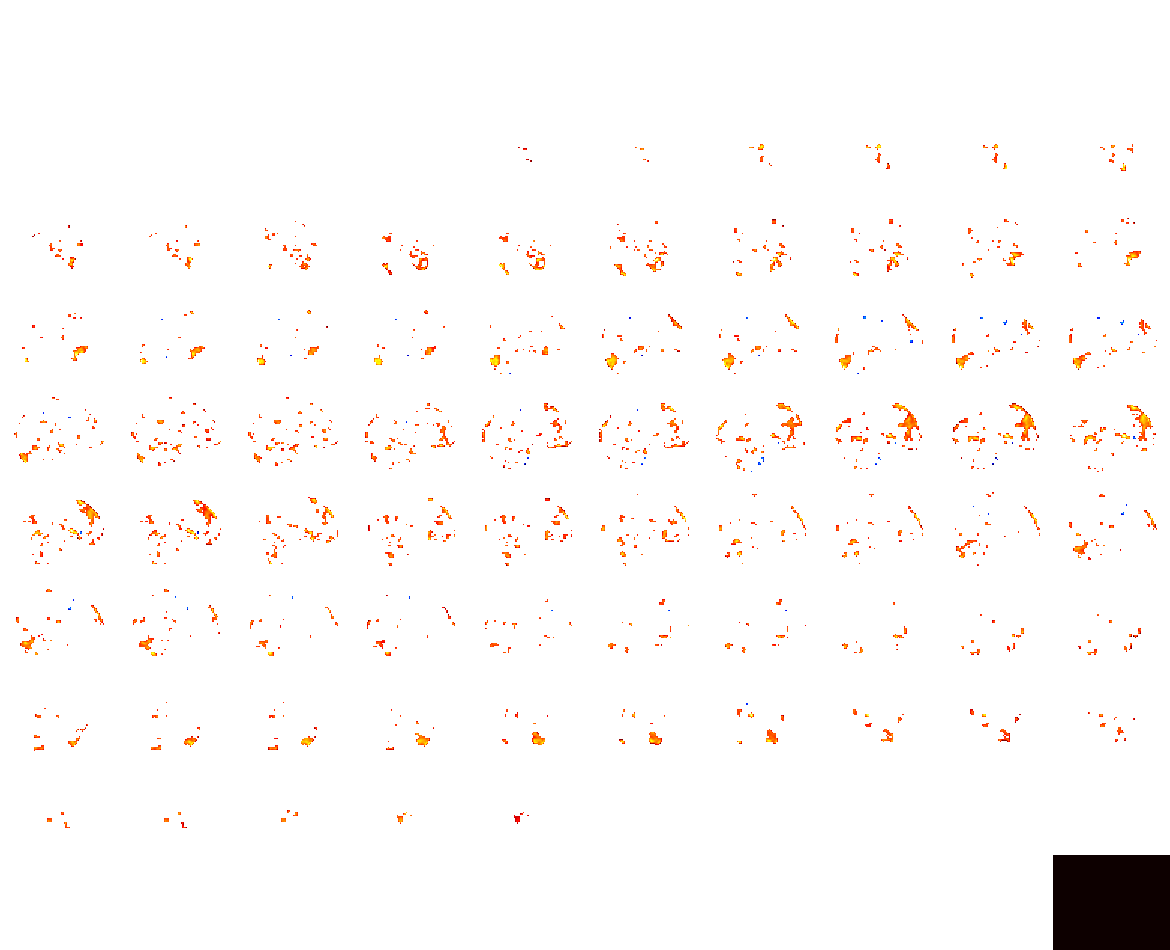

In [39]:
plotting.view_img(SA_FT, threshold=3, colorbar=True, title='SA - FT contrast')

In [33]:
frame_times = np.arange(vols) * tr
design_matrices = make_first_level_design_matrix(frame_times, all_events, hrf_model ='spm + derivative', add_regs = all_confounds)
plot_design_matrix(design_matrices)

AssertionError: Incorrect specification of additional regressors: length of regressors provided: 4, number of time-frames: 321.

In [ ]:
fmri_glm = FirstLevelModel()
fmri_glm = fmri_glm.fit(img, design_matrices=design_matrices)

In [20]:
import numpy as np

# For 321 volumes with TR = 2.0 seconds
n_scans = 321
tr = 2.0

# Standard format: start at 0, increment by TR
frame_times = np.arange(n_scans) * tr

print("Frame times shape:", frame_times.shape)  # Should be (321,)
print("First few frame times:", frame_times[:5])  # [0. 2. 4. 6. 8.]
print("Last few frame times:", frame_times[-5:])  # [632. 634. 636. 638. 640.]

Frame times shape: (321,)
First few frame times: [0. 2. 4. 6. 8.]
Last few frame times: [632. 634. 636. 638. 640.]


### Convert covariates into TR matched design matrix

In [ ]:
conds = ['SA','FT'] # Conditions of the experiment
design_matrix = []

# loop through and load the condition files
for run in range(1,runs+1):
    run_design = pd.DataFrame(np.zeros((vols, len(conds))), columns=conds)
    run_design_full = pd.DataFrame(np.zeros((vols, len(conds))), columns =conds)
    for cond in conds:

        cov = pd.read_csv(f'{input_directory}/sub-{subject}/ses-01/covs/SpaceLoc_spaceloc1001_Run{run}_{cond}.txt', sep='\t', header=None)
        cov.columns = ['onset', 'duration', 'value']
        # Downsample the covariate to match the TR
        cov['onset'] = (cov['onset'] / tr).astype(int)
        cov['duration'] = (cov['duration'] / tr).astype(int)

        #add a 1 to the design matrix for the onset of each condition
        run_design.loc[cov['onset'], cond] = 1


    #concatenate the design matrix for each run
    design_matrix.append(run_design.values)

  
   



### Load func images and concatenate them

In [45]:
img4d = []
for run in range(1, runs + 1):
    img = image.load_img(f'{input_directory}/sub-{subject}/ses-01/func/sub-{subject}_ses-01_task-spaceloc_run-0{run}_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz')
    print(img.shape)
    img4d.append(img.get_fdata())

# Stack the 3D images into a 4D image
#img4d_data = np.stack(img4d, axis=-1)
#print(f'img4d_data shape: {img4d.shape}')

(53, 65, 56, 321)
(53, 65, 56, 321)
(53, 65, 56, 321)


In [5]:
opt = dict()

# set important fields for completeness (but these would be enabled by default)
# wantlibrary = 1 -> fit HRF to each voxel 
# wantglmdenoise = 1 -> use GLMdenoise 
# wantfracridge = 1 -> use ridge regression to improve beta estimates 
opt['wantlibrary'] = 1
opt['wantglmdenoise'] = 1
opt['wantfracridge'] = 1

# for the purpose of this example we will keep the relevant outputs in memory
# and also save them to the disk
opt['wantfileoutputs'] = [1,1,1]
opt['wantmemoryoutputs'] = [0,0,0]
glmsingle_obj = GLM_single(opt)

In [8]:
glmsingle_obj = GLM_single()

In [ ]:
#create directory for the subject output
os.makedirs(f'{target_directory}/sub-{subject}/ses-01/glmsingle/', exist_ok=True)

#might need to change number of CPUs before running: export OPENBLAS_NUM_THREADS=4


start_time = time.time()
results_glmsingle = glmsingle_obj.fit(
    design_matrix,
    img4d,
    stimdur,
    tr,
    outputdir=f'{target_directory}/sub-{subject}/ses-01/glmsingle/')

elapsed_time = time.time() - start_time
print(f'GLM_single processing time: {elapsed_time:.2f} seconds')


*** DIAGNOSTICS ***:
There are 3 runs.
The number of conditions in this experiment is 2.
The stimulus duration corresponding to each trial is 20.00 seconds.
The TR (time between successive data points) is 1.00 seconds.
The number of trials in each run is: [10, 10, 10].
The number of trials for each condition is: [np.int64(15), np.int64(15)].
For each condition, the number of runs in which it appears: [np.int64(3), np.int64(3)].
For each run, how much ending buffer do we have in seconds? [np.int64(30), np.int64(30), np.int64(50)].
*** Saving design-related results to /zpool/vladlab/data_drive/fmri_tutorial/derivatives/sub-spaceloc1001/ses-01/glmsingle/DESIGNINFO.npy. ***
*** FITTING DIAGNOSTIC RUN-WISE FIR MODEL ***
*** Saving FIR results to /zpool/vladlab/data_drive/fmri_tutorial/derivatives/sub-spaceloc1001/ses-01/glmsingle/RUNWISEFIR.npy. ***

*** FITTING TYPE-A MODEL (ONOFF) ***

fitting model...
done.

preparing output...
done.

computing model fits...
done.

computing R^2...


: 

In [1]:
np.show_config()

NameError: name 'np' is not defined

In [ ]:
#create directory for the subject output
os.makedirs(f'{target_directory}/sub-{subject}/ses-01/glmsingle/design_full', exist_ok=True)


start_time = time.time()
results_glmsingle = glmsingle_obj.fit(
    design_matrix_full.values,
    img4d,
    stimdur,
    tr,
    outputdir=f'{target_directory}/sub-{subject}/ses-01/glmsingle/design_full')

elapsed_time = time.time() - start_time
print(f'GLM_single processing time: {elapsed_time:.2f} seconds')


### load results

In [38]:
design_info = np.load(f'{target_directory}/sub-{subject}/ses-01/glmsingle/DESIGNINFO.npy', allow_pickle=True).item()
results = np.load(f'{target_directory}/sub-{subject}/ses-01/glmsingle/TYPED_FITHRF_GLMDENOISE_RR.npy', allow_pickle=True).item()
results_onoff = np.load(f'{target_directory}/sub-{subject}/ses-01/glmsingle/TYPEA_ONOFF.npy', allow_pickle=True).item()
#results_full = np.load(f'{target_directory}/sub-{subject}/ses-01/glmsingle/design_full/TYPED_FITHRF_GLMDENOISE_RR.npy', allow_pickle=True).item()

In [39]:
#stack design matrix
full_design = np.vstack(design_matrix)
#using design_df, extract each 1 value in order and list its scondition 
conditions = []
condition_index = []
#loop through each row of the design_df
for i in range(len(full_design)):
    #check if the row is all zeros
    if np.all(full_design[i,:] == 0):
        # if so, skip this row
        continue
    #get the columns where the value is 1
    cols = np.where(full_design[i,:] == 1)[0]
    #get the condition name from the first column
    condition = conds[cols[0]]
    #append the condition to the list
    conditions.append(condition)
    #append the index of the condition to the list
    condition_index.append(i)

In [40]:
cond_inds = []
for i in range(0,len(conds)):
    cond_inds.append([kk for kk, condition in enumerate(conditions) if condition in conds[i]])


In [41]:
all_betas.shape

(53, 65, 56, 30)

In [42]:
all_betas = results['betasmd']

#extract betas from SA and FT conditions
sa_betas = all_betas[:,:,:,cond_inds[0]]
ft_betas = all_betas[:,:,:,cond_inds[1]]

#mask out using the brain mask
sa_betas = sa_betas * brain_mask_data[..., np.newaxis]
ft_betas = ft_betas * brain_mask_data[..., np.newaxis]


#convert nans to zeros
#sa_betas = np.nan_to_num(sa_betas)
#ft_betas = np.nan_to_num(ft_betas)
#

#do a t-test between the numpy arrays 
from scipy import stats
t_stat, p_value = stats.ttest_rel(sa_betas, ft_betas, axis=3)

#convert to a z-score
z_map = stats.norm.ppf(1 - p_value / 2)  # two-tailed test

# Save the z_map as a Nifti image
z_map_img = image.new_img_like(brain_mask, z_map)
t_map_img = image.new_img_like(brain_mask, t_stat)

#smooth both maps
z_map_img = image.smooth_img(z_map_img, fwhm=6)
t_map_img = image.smooth_img(t_map_img, fwhm=6)



In [43]:
sa_betas.shape

(53, 65, 56, 15)

In [44]:
#check for nans in sa_betas and ft_betas
if np.isnan(sa_betas).any() or np.isnan(ft_betas).any():
    print("NaN values found in betas arrays.")
else:
    print("No NaN values found in betas arrays.")

No NaN values found in betas arrays.


In [45]:
all_betas = results['betasmd']

#extract betas from SA and FT conditions
sa_betas = np.nanmedian(all_betas[:,:,:,cond_inds[0]], axis=3)
ft_betas = np.nanmedian(all_betas[:,:,:,cond_inds[1]], axis= 3)

sa_betas[brain_mask_data==0] = np.nan
ft_betas[brain_mask_data==0] = np.nan

#set values more than 3 standard deviations from the mean to NaN
sa_betas[np.abs(sa_betas - np.nanmean(sa_betas)) > 3 * np.nanstd(sa_betas)] = np.nan
ft_betas[np.abs(ft_betas - np.nanmean(ft_betas)) > 3 * np.nanstd(ft_betas)] = np.nan

#convert them to nifti
sa_map = image.new_img_like(brain_mask,sa_betas)
ft_map = image.new_img_like(brain_mask, ft_betas)

#smooth the maps
sa_map = image.smooth_img(sa_map, fwhm=6)
ft_map = image.smooth_img(ft_map, fwhm=6)

#create subtraction map
sub_map = image.new_img_like(brain_mask, sa_betas - ft_betas)
#smooth the subtraction map
sub_map = image.smooth_img(sub_map, fwhm=6)


In [46]:
onoff = results_onoff['betasmd']
onoff = np.nanmedian(onoff, axis=3)
onoff[brain_mask_data==0] = np.nan

#get rid of outliers
onoff[np.abs(onoff - np.nanmean(onoff)) > 3 * np.nanstd(onoff)] = np.nan


#convert to nifti
onoff_map = image.new_img_like(brain_mask, onoff)
#smooth the onoff map
onoff_map = image.smooth_img(onoff_map, fwhm=6)


In [47]:
#save the maps
sa_map.to_filename(f'{target_directory}/sub-{subject}/ses-01/glmsingle/sa_betas.nii.gz')
ft_map.to_filename(f'{target_directory}/sub-{subject}/ses-01/glmsingle/ft_betas.nii.gz')
sub_map.to_filename(f'{target_directory}/sub-{subject}/ses-01/glmsingle/subtraction_map.nii.gz')

onoff_map.to_filename(f'{target_directory}/sub-{subject}/ses-01/glmsingle/onoff_map.nii.gz')

#save z and t maps
z_map_img.to_filename(f'{target_directory}/sub-{subject}/ses-01/glmsingle/z_map.nii.gz')
t_map_img.to_filename(f'{target_directory}/sub-{subject}/ses-01/glmsingle/t_map.nii.gz')

In [54]:
sa_betas.shape

(53, 65, 56)

In [28]:
np.nanmean(sa_betas.flatten())

np.float32(0.020867405)

/home/tuc66980@tu.temple.edu/.conda/envs/fmri/lib/python3.13/site-packages/nilearn/plotting/html_stat_map.py:205: UserWarning: Non-finite values detected. These values will be replaced with zeros.
  data = safe_get_data(stat_map_img, ensure_finite=True)
/home/tuc66980@tu.temple.edu/.conda/envs/fmri/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:868: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)



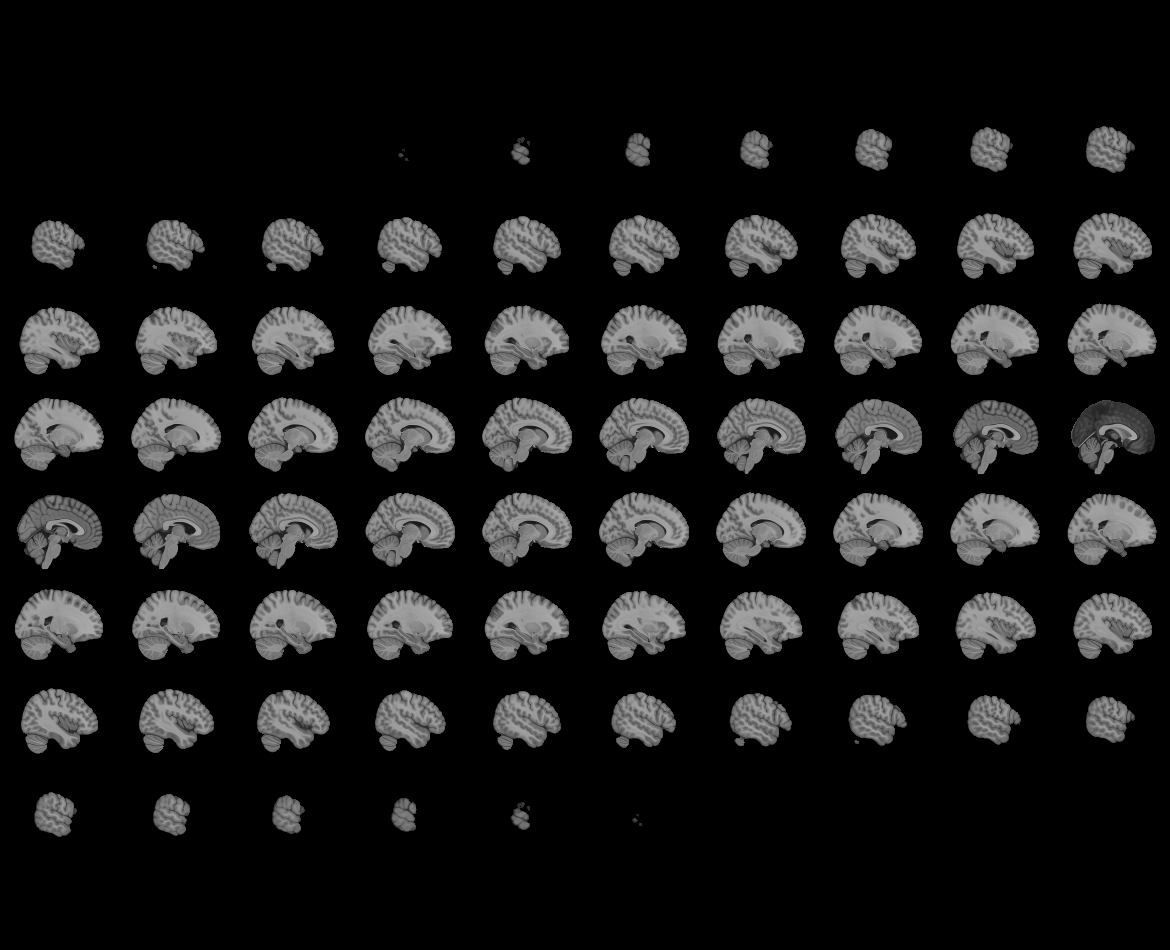
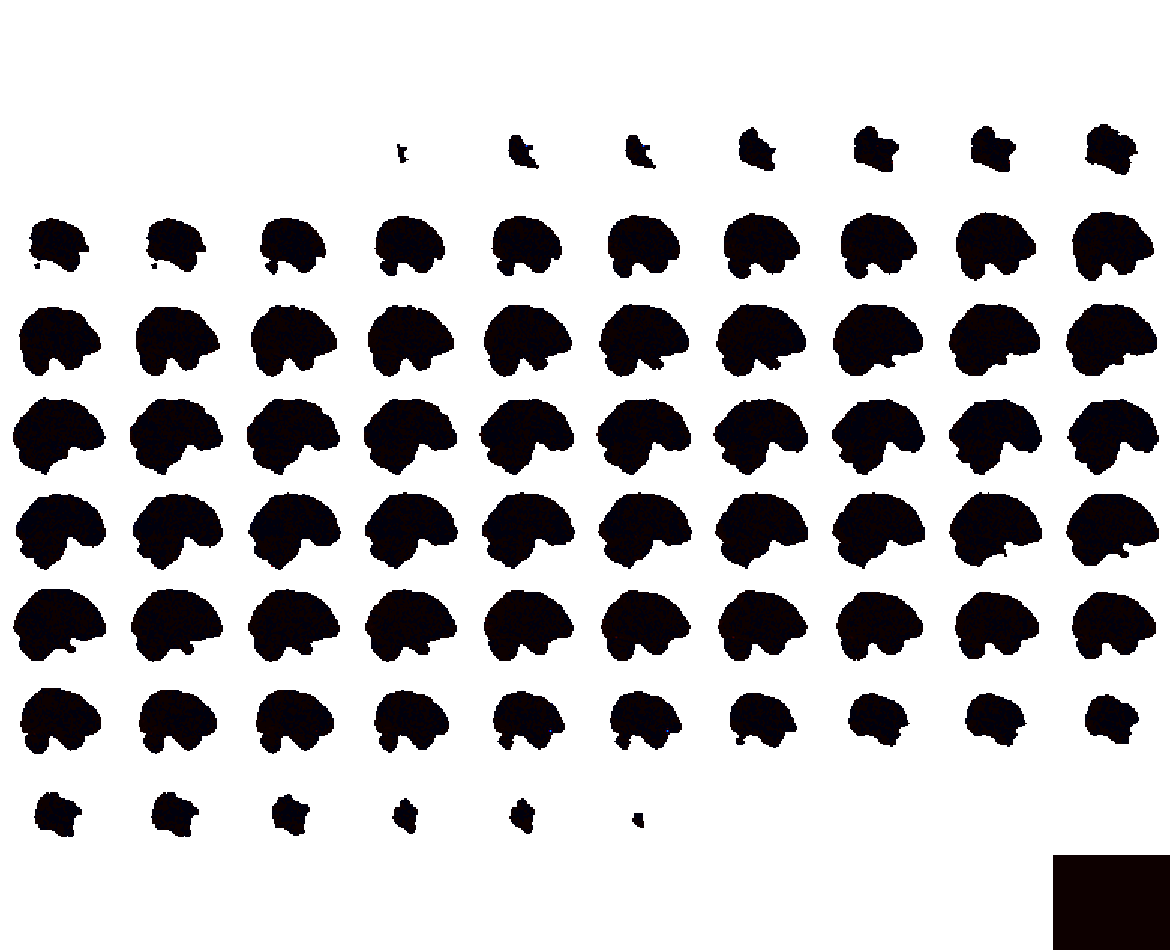

In [58]:
plotting.view_img(sa_map)